# Import dependencies

In [1]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import resampy

# Defining functions for conversion of audio files into spectograms for convolution process

In [2]:
def resample_16k(wav, sample_rate):
    return resampy.resample(wav, sample_rate, 16000)

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tf.numpy_function(resample_16k, [wav, sample_rate], tf.float32)
    return wav

In [3]:
# Preprocess

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]  # Crop or pad the audio to a fixed size (e.g., 48000 samples)
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)  # Pad with zeros if needed
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)  # eliminate negatives
    spectogram = tf.expand_dims(spectogram, axis=2)  # adds 1 grayscale channel to final spectogram for convolution processing
    return spectogram, label

# Processing data

In [4]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

pos_files = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg_files = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

In [5]:
# Make labels
positives = pos_files.map(lambda x: (x, tf.constant(1, dtype=tf.float32)))
negatives = neg_files.map(lambda x: (x, tf.constant(0, dtype=tf.float32)))

data = positives.concatenate(negatives)

In [6]:
#MCSHBAP for optimizing performance

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

# train test split

train_data = data.take(20)
test_data = data.skip(20).take(8)

# Model building

In [7]:
# Build and compile the model (you can apply the suggested improvements here)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

# Training the model

In [9]:
#Train the model
hist = model.fit(train_data, epochs=8, validation_data=test_data)

Epoch 1/8
20/20 [==============================] - 123s 2s/step - loss: 0.6228 - accuracy: 0.8938 - precision: 0.7917 - recall: 0.8444 - val_loss: 0.5699 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.4839
Epoch 2/8
20/20 [==============================] - 35s 2s/step - loss: 0.0840 - accuracy: 0.9750 - precision: 0.9770 - recall: 0.9341 - val_loss: 0.0156 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/8
20/20 [==============================] - 35s 2s/step - loss: 0.0432 - accuracy: 0.9906 - precision: 0.9785 - recall: 0.9891 - val_loss: 0.0071 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/8
20/20 [==============================] - 36s 2s/step - loss: 0.0414 - accuracy: 0.9937 - precision: 1.0000 - recall: 0.9767 - val_loss: 0.0045 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/8
20/20 [==============================] - 36s 2s/step - loss: 0.0097 - accuracy: 1.0000 - precision: 1.000

# Metrics plot

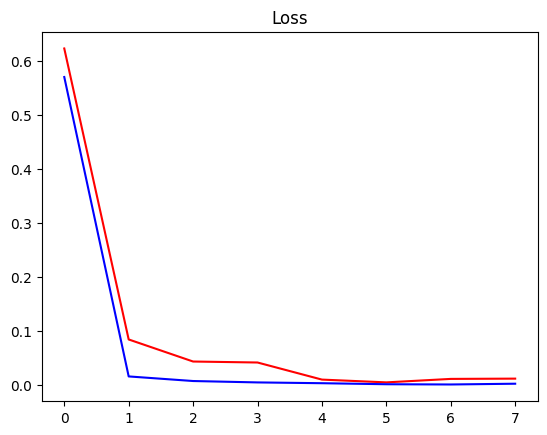

In [10]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

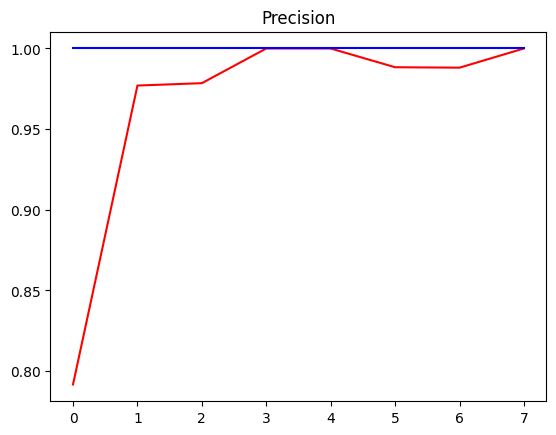

In [11]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

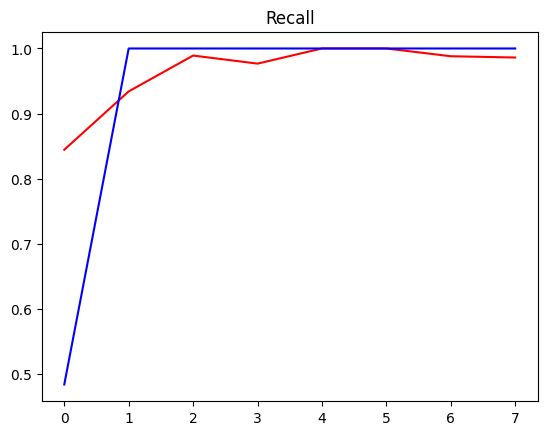

In [12]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Make a Prediction on a Single Clip

In [13]:
X_test, y_test = test_data.as_numpy_iterator().next()

In [14]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 450ms/step


In [15]:
# Convert logits to class
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [16]:
yhat

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]

In [17]:
y_test.astype(int)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

# Build Forest Parsing Functions

In [18]:
# Converting mp3 files into WAV for predictions

from pydub import AudioSegment
import os
import glob

def convert_mp3_to_wav(mp3_file, wav_file):
    audio = AudioSegment.from_mp3(mp3_file)
    audio.export(wav_file, format="wav")

# Function to convert all MP3 files in a folder to WAV files and save to a different directory
def convert_mp3_folder_to_wav(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    mp3_files = glob.glob(os.path.join(input_folder, "*.mp3"))
    for mp3_file in mp3_files:
        file_name = os.path.basename(mp3_file)
        wav_file = os.path.join(output_folder, os.path.splitext(file_name)[0] + ".wav")
        convert_mp3_to_wav(mp3_file, wav_file)

# Example usage
input_folder_path = "./data/Forest Recordings/"
output_folder_path = "./data/Forest Recordings - wav/"

convert_mp3_folder_to_wav(input_folder_path, output_folder_path)


In [19]:
wav = os.path.join('data', 'Forest Recordings - wav', 'recording_00.wav')

In [20]:
wav = load_wav_16k_mono(wav)

In [21]:
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 0.        ,  0.        ,  0.        , ..., -0.00416745,
       -0.00395267,  0.00087286], dtype=float32)>

In [22]:
# slicing the 2880666 steps long audio into 48000 steps for prediciting

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [23]:
samples, index = audio_slices.as_numpy_iterator().next()

In [25]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [26]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [27]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 6s 1s/step


In [28]:
from itertools import groupby

In [29]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [30]:
calls

8

In [31]:
# Applying predict method for all the files in folder

In [32]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings - wav')):
    FILEPATH = os.path.join('data','Forest Recordings - wav', file)
    
    wav = load_wav_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [33]:
results

{'recording_00.wav': array([[2.0034948e-01],
        [3.3943865e-02],
        [7.6841745e-03],
        [9.2771423e-01],
        [1.0000000e+00],
        [4.4147499e-02],
        [6.9001121e-03],
        [1.0855983e-02],
        [2.1549847e-02],
        [5.8471866e-02],
        [8.3163761e-02],
        [4.0228546e-02],
        [3.4914378e-02],
        [9.9988163e-01],
        [1.0000000e+00],
        [1.7216900e-02],
        [7.7392439e-09],
        [1.3037891e-02],
        [9.8925561e-02],
        [3.7747838e-02],
        [4.8272565e-02],
        [5.2675284e-02],
        [2.7960247e-01],
        [9.7946614e-01],
        [1.0000000e+00],
        [3.6558460e-03],
        [1.2202170e-03],
        [4.5274258e-02],
        [2.4342680e-04],
        [6.0361963e-02],
        [2.5675423e-02],
        [4.1177186e-01],
        [6.4752256e-03],
        [1.4933932e-04],
        [1.0834788e-01],
        [6.8847458e-03],
        [1.0000000e+00],
        [6.1752874e-04],
        [2.2772985e-02],
     

In [34]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.wav': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.wav': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.wav': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.wav': [0,
  0,
  0,
  

In [35]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.wav': 5,
 'recording_01.wav': 0,
 'recording_02.wav': 0,
 'recording_03.wav': 0,
 'recording_04.wav': 4,
 'recording_05.wav': 0,
 'recording_06.wav': 5,
 'recording_07.wav': 2,
 'recording_08.wav': 24,
 'recording_09.wav': 0,
 'recording_10.wav': 5,
 'recording_11.wav': 3,
 'recording_12.wav': 0,
 'recording_13.wav': 0,
 'recording_14.wav': 0,
 'recording_15.wav': 2,
 'recording_16.wav': 5,
 'recording_17.wav': 3,
 'recording_18.wav': 3,
 'recording_19.wav': 0,
 'recording_20.wav': 0,
 'recording_21.wav': 1,
 'recording_22.wav': 2,
 'recording_23.wav': 5,
 'recording_24.wav': 0,
 'recording_25.wav': 15,
 'recording_26.wav': 2,
 'recording_27.wav': 0,
 'recording_28.wav': 13,
 'recording_29.wav': 0,
 'recording_30.wav': 3,
 'recording_31.wav': 1,
 'recording_32.wav': 2,
 'recording_33.wav': 0,
 'recording_34.wav': 4,
 'recording_35.wav': 0,
 'recording_36.wav': 0,
 'recording_37.wav': 3,
 'recording_38.wav': 1,
 'recording_39.wav': 13,
 'recording_40.wav': 1,
 'recording_

# Exporting the data to csv for easier access of results

In [36]:
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])